In [1]:
import numpy as np
import math
import gym
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
tf.get_logger().setLevel('INFO')
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange
from datetime import datetime
import pathlib

from ddpg import DDPG
from erl import ERL

from car_env import CarEnv

In [2]:
# env_name = 'InvertedPendulum-v2'
env_name = 'RLCar-v0'
alg_name = 'ERL'
# alg_name = 'DDPG'
name = 'test-4rays-slow-car'


In [3]:
pathlib.Path('buffers').mkdir(parents=True, exist_ok=True)
pathlib.Path('models' ).mkdir(parents=True, exist_ok=True)

env = None
if env_name == 'RLCar-v0':
    env = CarEnv(file_name = 'maps/maptest.txt', num_rays = 4)
else:
    env = gym.make(env_name)

In [4]:
try:
    actor  = tf.keras.models.load_model(f'models/{env_name}/{alg_name}-{name}-actor')
    critic = tf.keras.models.load_model(f'models/{env_name}/{alg_name}-{name}-critic')
    print('Models loaded from disk')

except OSError:
    state_size = int(np.prod(env.observation_space.shape))
    action_size = int(np.prod(env.action_space.shape))
    try:
        action_high = float(env.action_space.high)
    except:
        action_high = float(env.action_space.high[0])

    actor = Sequential([
        Input(state_size),
        Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        Dense(action_size, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        Lambda(lambda x: x*action_high)
    ])
    critic = Sequential([
        Input(state_size+action_size),
        Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        Dense(1)
    ])
    print('Fresh models created')

Fresh models created


In [5]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/' + current_time + '/train'
test_log_dir = 'logs/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [6]:
adam = Adam()
action_noise = lambda x: 10**(-3-2*x) # from 0.001 to 0.00001
# alg = DDPG(env, actor, critic, adam, name = name, actions_per_epoch=4, training_steps_per_epoch=4,
#     action_noise = action_noise, buffer_size=10**4) #, train_summary_writer = train_summary_writer, test_summary_writer = test_summary_writer)
alg = ERL(env, actor, critic, adam, name = name, episodes_per_actor=1, episodes_rl_actor=5, training_steps_per_epoch=10,
    action_noise = action_noise, mutation_rate = 0.00005, buffer_size = 10**5) #, train_summary_writer = train_summary_writer, test_summary_writer = test_summary_writer)

Fresh buffer created


In [7]:
try:
    stats = alg.train(epochs = 500, batch_size=256, test_every=10, render_test=True)

except (KeyboardInterrupt, SystemExit) as e:
    print('Interrupted')
    stats = alg.stats
    
alg.buffer.save_to_file()
alg.save_models()
alg.env.close()

 11%|█         | 11247/100000 [00:03<00:25, 3504.21it/s]
Interrupted
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/erl/RLCar-v0/test-4rays-slow-car-actor/assets


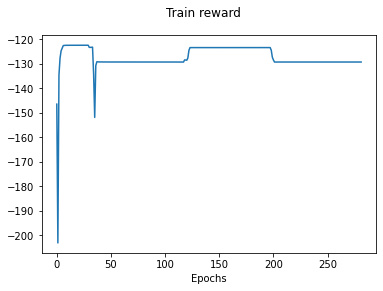

In [8]:
plt.plot(stats['reward'])
plt.suptitle('Train reward')
plt.xlabel('Epochs')
directory = f'imgs/{alg_name}/{env_name}'
pathlib.Path(directory).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{directory}/train_reward_{name}.jpg')

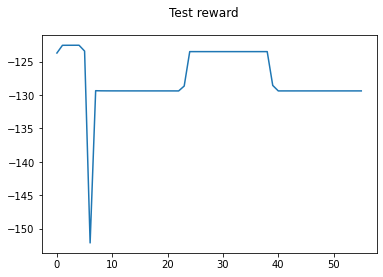

In [9]:
plt.plot(stats['test_reward'])
plt.suptitle('Test reward')
# plt.xlabel('Hundreds of epochs')
directory = f'imgs/{alg_name}/{env_name}'
pathlib.Path(directory).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{directory}/test_reward_{name}.jpg')

In [10]:
alg.test(10)

-129.38677081395164

In [11]:
def ewma(xs, beta=0.9):
    ma = np.zeros_like(xs)
    for i in range(len(xs)-1):
        ma[i+1] = beta*ma[i]+(1-beta)*xs[i]
    for i in range(len(xs)):
        ma[i] = ma[i]/(1-beta**i)
    return ma

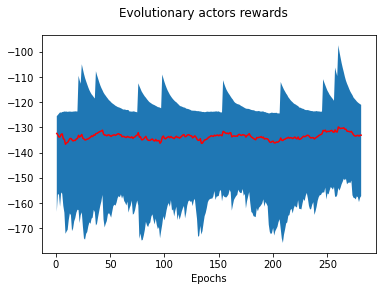

In [12]:
actors_rewards = np.array(stats['actors_rewards'])
mean = np.mean(actors_rewards, axis=1)
low  = np.min(actors_rewards, axis=1)
high = np.max(actors_rewards, axis=1)

plt.fill_between(np.arange(len(mean)), ewma(low), ewma(high))
plt.plot(ewma(mean), 'r')
# plt.ylim(0, 800)
directory = f'imgs/{alg_name}/{env_name}'
pathlib.Path(directory).mkdir(parents=True, exist_ok=True)

plt.suptitle('Evolutionary actors rewards')
plt.xlabel('Epochs')

plt.savefig(f'{directory}/actors_reward_{name}.jpg')
